In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import scipy.signal
import torch
import torch.nn as nn
import heapq
from sklearn import preprocessing 

In [30]:
#inisialize
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")

print(f'Devices: {device}')

Devices: mps


In [31]:
#read file and load models path
h5path = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/h5/'
pthpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/pth/'
#read mat file
matpath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/Data/matlib/'
figurepath = '/Users/mclinwong/GitHub/CodesReproduction/DCN-DOA/ReproducedCodes/Figures/'
read_temp=scipy.io.loadmat(matpath + 'data2_testall.mat')
S_est=read_temp['S_est']
S_est = S_est.transpose(0, 2, 1)
[r2, K, I] = np.shape(S_est)
S_abs = np.zeros((r2, I*2))
for i in range(r2):
    for j in range(I):
        S_abs[i, j] = S_est[i, 0, j]
        S_abs[i, I+j] = S_est[i, 1, j]    

S_label=read_temp['S_label']
R_est=read_temp['R_est']
DOA_train=read_temp['DOA_train']
theta=read_temp['theta']
gamma=read_temp['gamma']
gamma_R=read_temp['gamma_R']
S_label1 = np.expand_dims(S_label, 2)
normalizer = preprocessing.Normalizer().fit(R_est)

[r2,c]=np.shape(R_est)
[r2,I]=np.shape(S_label)
print(f'r2: {r2}, I: {I}, c: {c}')
print(f'S_est: {S_est.shape}, S_abs: {S_abs.shape} \nS_label: {S_label.shape},\nS_label1: {S_label1.shape} ,\nR_est: {R_est.shape}')


DOA = np.arange(I)-60
L = 120

r2: 321, I: 120, c: 56
S_est: (321, 2, 120), S_abs: (321, 240) 
S_label: (321, 120),
S_label1: (321, 120, 1) ,
R_est: (321, 56)


In [32]:
class CNN_ReLu(nn.Module):
    def __init__(self):
        super(CNN_ReLu, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.cnn_1(x))
        x = self.relu(self.cnn_2(x))
        x = self.relu(self.cnn_3(x))
        x = self.relu(self.cnn_4(x))
        return x
cnnrelu = torch.load(pthpath + 'cnnrelu.pth')

In [33]:
class CNN_tanh(nn.Module):
    def __init__(self):
        super(CNN_tanh, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.cnn_1(x))
        x = self.tanh(self.cnn_2(x))
        x = self.tanh(self.cnn_3(x))
        x = self.tanh(self.cnn_4(x))
        return x
cnntanh = torch.load(pthpath + 'cnntanh.pth')

In [34]:
class CNN_sigmoid(nn.Module):
    def __init__(self):
        super(CNN_sigmoid, self).__init__()
        self.cnn_1 = nn.Conv1d(in_channels=2, out_channels=12, kernel_size=25, padding=12)
        self.cnn_2 = nn.Conv1d(in_channels=12, out_channels=6, kernel_size=15, padding=7)
        self.cnn_3 = nn.Conv1d(in_channels=6, out_channels=3, kernel_size=5, padding=2)
        self.cnn_4 = nn.Conv1d(in_channels=3, out_channels=1, kernel_size=3, padding=1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.cnn_1(x))
        x = self.sigmoid(self.cnn_2(x))
        x = self.sigmoid(self.cnn_3(x))
        x = self.sigmoid(self.cnn_4(x))
        return x
cnnsigmoid = torch.load(pthpath + 'cnnsigmoid.pth')

In [35]:
class DNN_ReLU(nn.Module):
    def __init__(self):
        super(DNN_ReLU, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        return x
dnnrelu = torch.load(pthpath + 'dnnrelu.pth') 

In [36]:
class DNN_Tanh(nn.Module):
    def __init__(self):
        super(DNN_Tanh, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.tanh = nn.Tanh()
    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.tanh(self.fc4(x))
        return x
dnntanh = torch.load(pthpath + 'dnntanh.pth')

In [37]:
class DNN_Sigmoid(nn.Module):
    def __init__(self):
        super(DNN_Sigmoid, self).__init__()
        self.fc1 = nn.Linear(2*L, int(2*L/3))
        self.fc2 = nn.Linear(int(2*L/3), int(4*L/9))
        self.fc3 = nn.Linear(int(4*L/9), int(2*L/3))
        self.fc4 = nn.Linear(int(2*L/3), L)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x
dnnsigmoid = torch.load(pthpath + 'dnnsigmoid.pth')

In [38]:
def Test(model, inputx, flag):
    #flag==0 for CNN, flag==1 for DNN
    model = model.to(device)
    model.eval()
    ls = []
    for i in range(r2):
        with torch.no_grad():
            if flag==0:
                x = torch.from_numpy(inputx[i,:,:]).float().to('cpu')
            if flag==1:
                x = torch.from_numpy(inputx[i,:]).float().to('cpu')
            x = x.to(device)
            y = model(x)
            y = y.cpu().numpy()
            #Turn the output into a 1D array
            y = np.squeeze(y)
            ls.append(y)
    predict = np.array(ls)
    return predict

In [39]:
def DOAPredict(predict, height = 0.1, nodetect = -200):
    #flag==0 for CNN, flag==1 for DNN
    peak = np.zeros((K, r2))
    for i in range(r2):
        li = predict[i,:]
        peaks_st = np.zeros((K))
        peaks_st = peaks_st + nodetect
        peaks,_ = scipy.signal.find_peaks(li, height=height)
        maxamp = heapq.nlargest(K, li[peaks])
        rank = np.zeros(np.shape(maxamp)[0])
        for s in range(np.shape(maxamp)[0]):
            rank[s] = np.where(li==maxamp[s])[0].item()
        
        if len(peaks) == K:
            peaks_st = peaks
        elif len(peaks) == 0:
            peaks_st = peaks_st
        elif len(peaks) < K:
            for t in range(len(peaks)):
                peaks_st[t] = peaks[t]
        elif len(peaks) > K:
            for j in range(K):
                peaks_st[j] = rank[j]

        peak[:,i] = sorted(peaks_st, reverse=True)

    return peak-60

In [40]:
predict_cnntanh = Test(cnntanh, S_est, 0)
doa_cnntanh = DOAPredict(predict_cnntanh)
predict_cnnrelu = Test(cnnrelu, S_est, 0)
doa_cnnrelu = DOAPredict(predict_cnnrelu)
predict_cnnsigmoid = Test(cnnsigmoid, S_est, 0)
doa_cnnsigmoid = DOAPredict(predict_cnnsigmoid)

predict_dnntanh = Test(dnntanh, S_abs, 1)
doa_dnntanh = DOAPredict(predict_dnntanh)
predict_dnnrelu = Test(dnnrelu, S_abs, 1)
doa_dnnrelu = DOAPredict(predict_dnnrelu)
predict_dnnsigmoid = Test(dnnsigmoid, S_abs, 1)
doa_dnnsigmoid = DOAPredict(predict_dnnsigmoid)

doa_sbl = DOAPredict(gamma)
doa_sblr = DOAPredict(gamma_R)

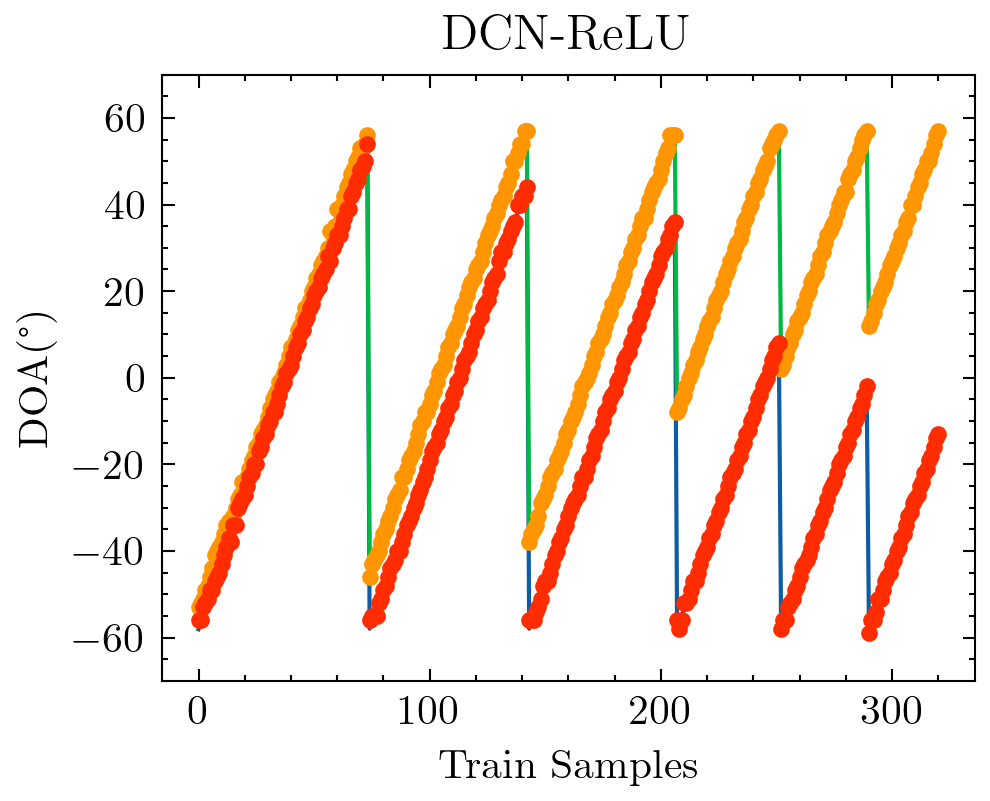

In [41]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_cnnrelu.T,'.')
    plt.title('DCN-ReLU')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_ReLU.pdf')
    plt.show()
    

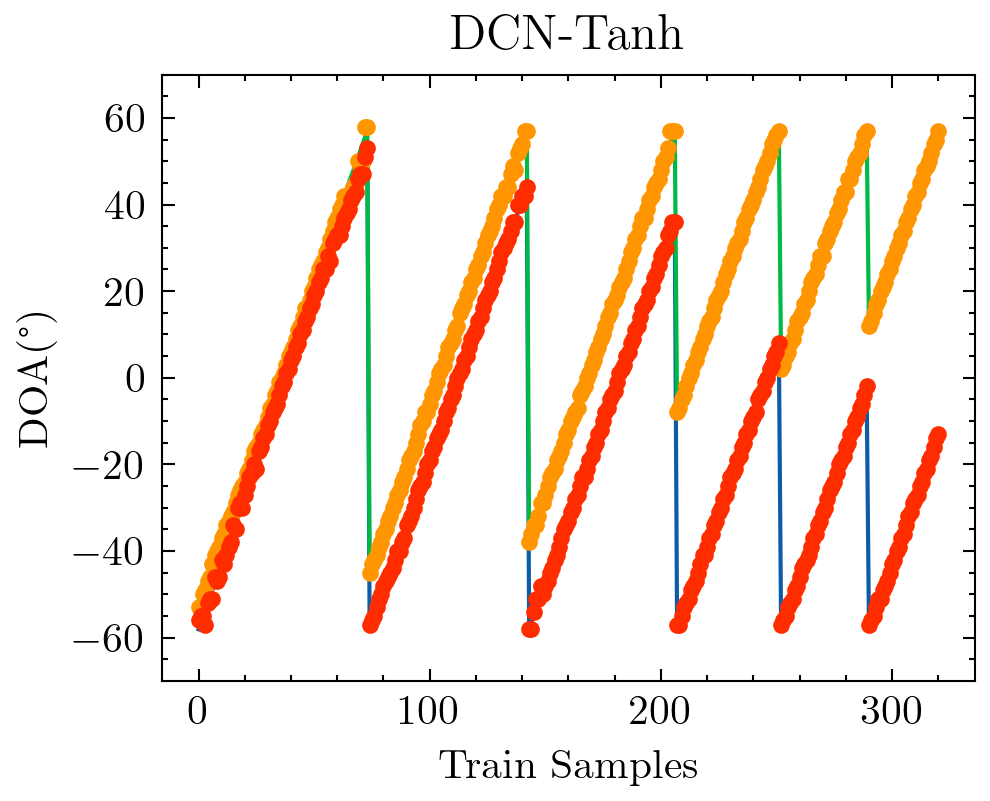

In [42]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_cnntanh.T,'.')
    plt.title('DCN-Tanh')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_Tanh.pdf')
    plt.show()

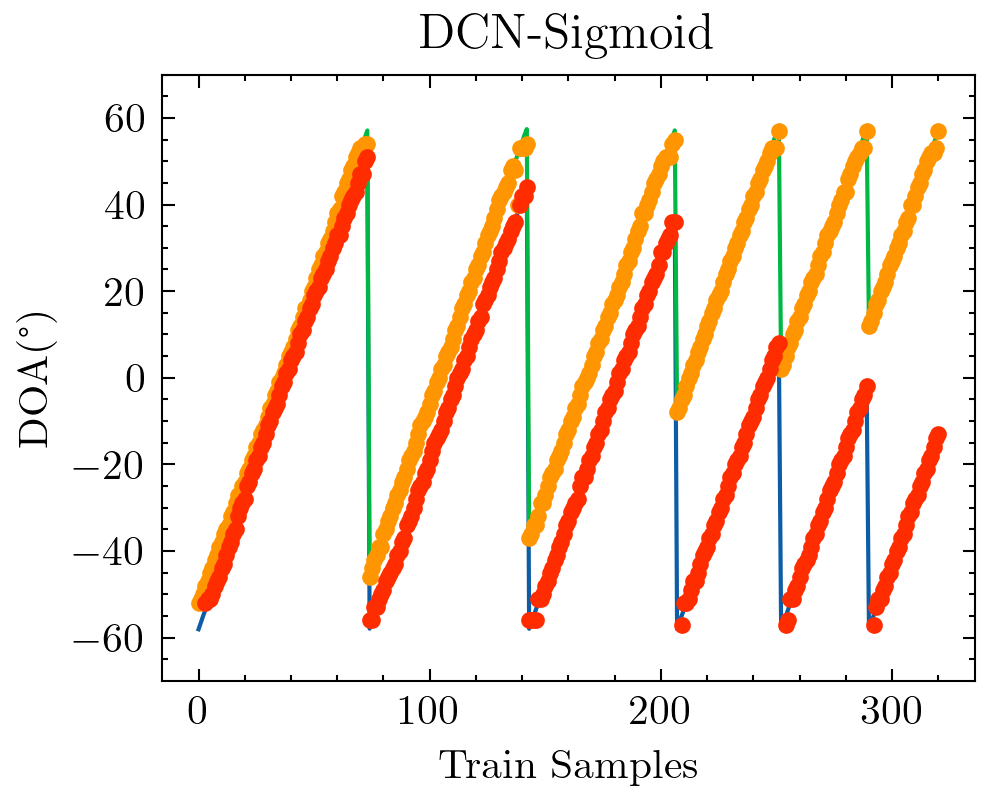

In [43]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_cnnsigmoid.T,'.')
    plt.title('DCN-Sigmoid')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_Sigmoid.pdf')
    plt.show()

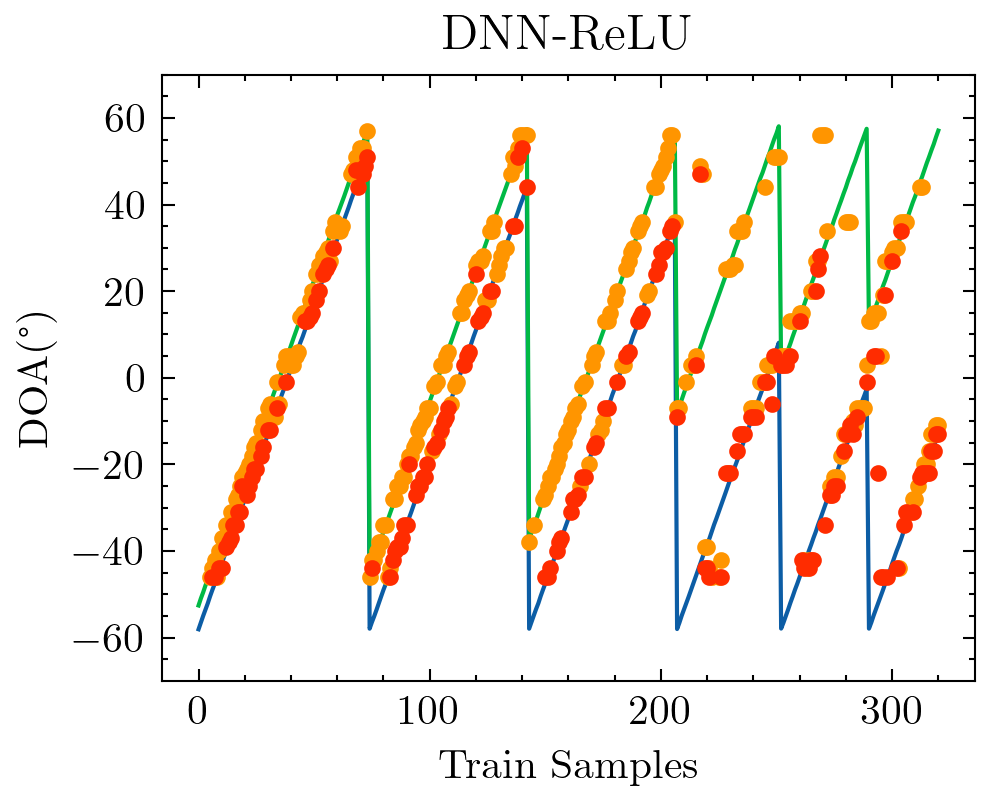

In [44]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_dnnrelu.T,'.')
    plt.title('DNN-ReLU')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_ReLU.pdf')
    plt.show()

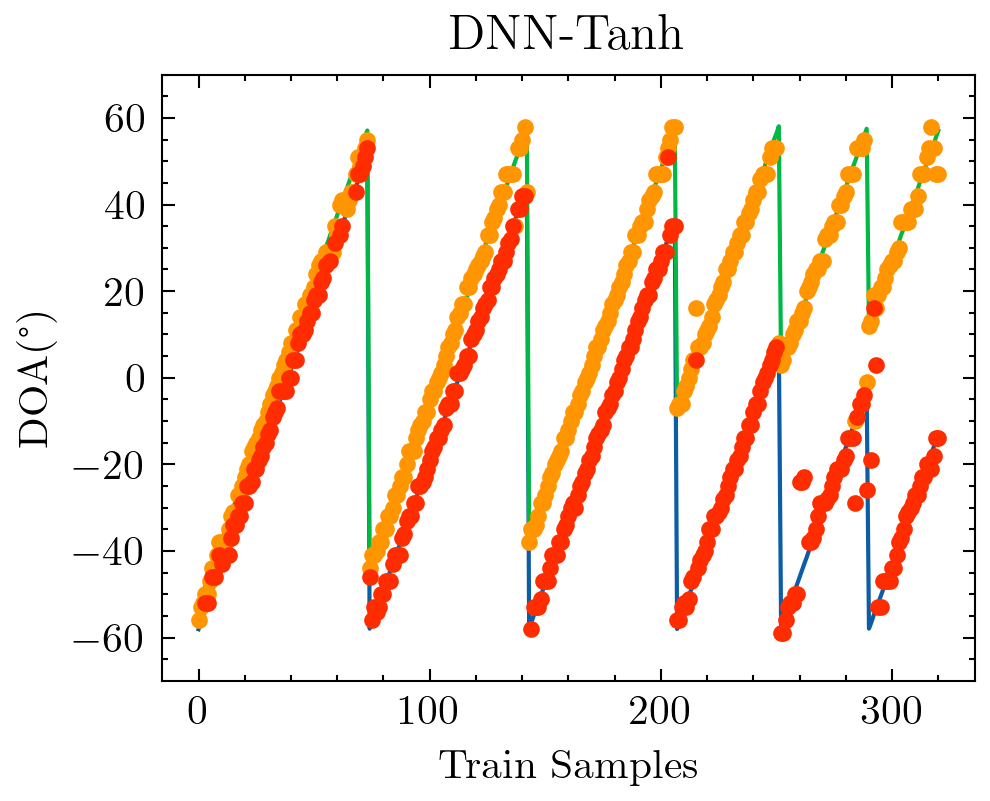

In [45]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_dnntanh.T,'.')
    plt.title('DNN-Tanh')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_Tanh.pdf')
    plt.show()

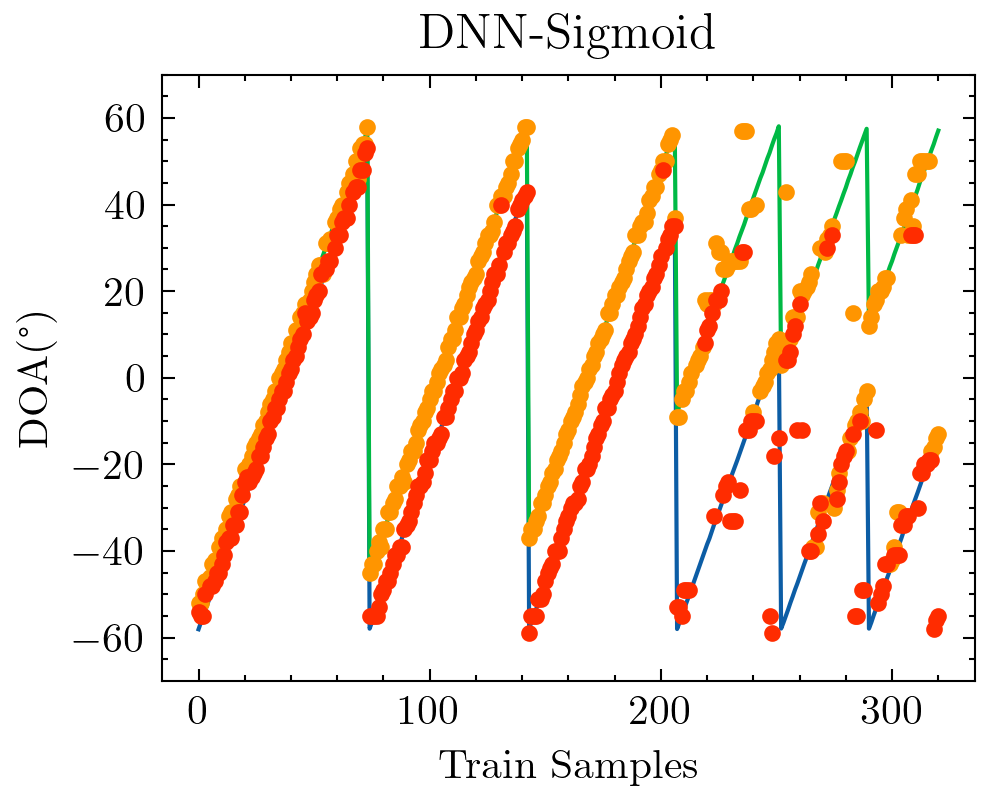

In [46]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_dnnsigmoid.T,'.')
    plt.title('DNN-Sigmoid')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_Sigmoid.pdf')
    plt.show()

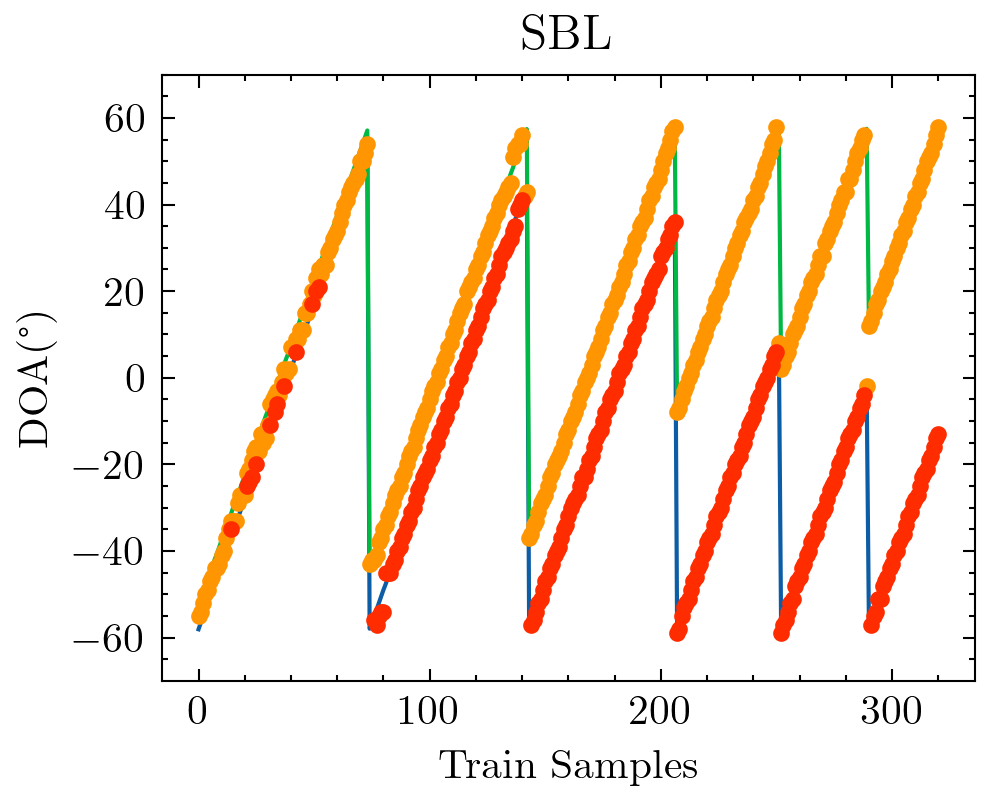

In [47]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_sbl.T,'.')
    plt.title('SBL')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/SBL.pdf')
    plt.show()

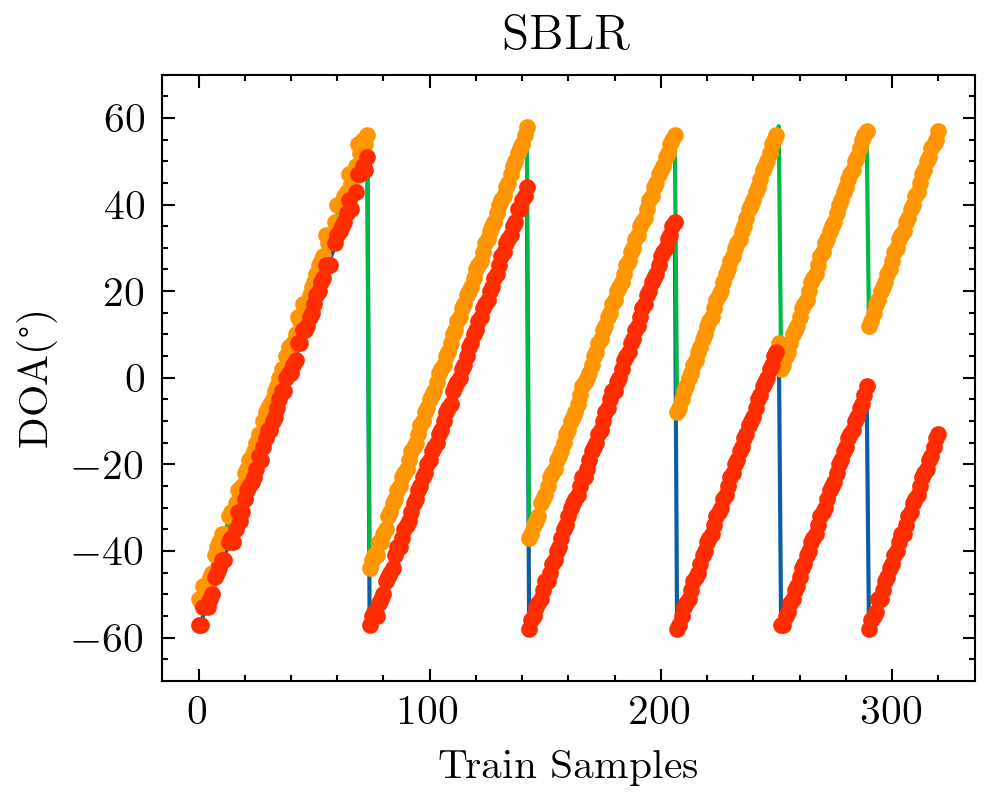

In [48]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-70,70)
    plt.plot(DOA_train.T)
    plt.plot(doa_sblr.T,'.')
    plt.title('SBLR')
    plt.xlabel('Train Samples')
    plt.ylabel('DOA(°)')
    plt.savefig(figurepath + 'SampleIndex/SBLR.pdf')
    plt.show()

# Estimation Error

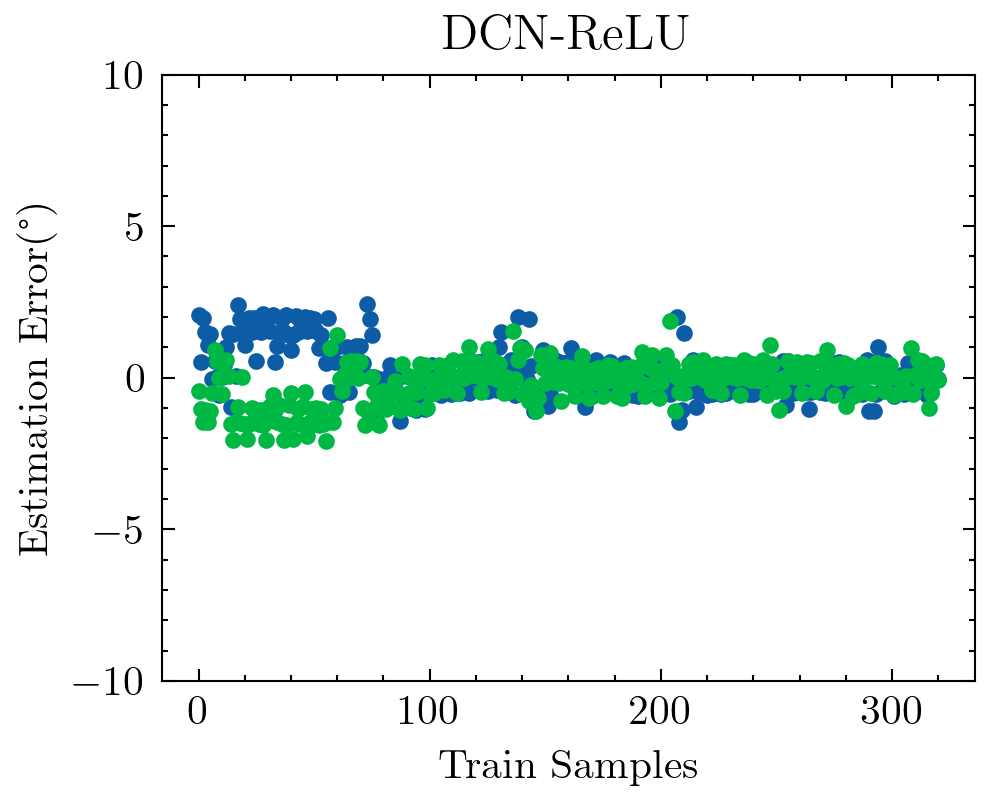

In [49]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-10,10)
    a = np.zeros((K, r2))
    a[0,:] = doa_cnnrelu[1,:]
    a[1,:] = doa_cnnrelu[0,:]
    plt.plot((a - DOA_train).T,'.')
    plt.title('DCN-ReLU')
    plt.xlabel('Train Samples')
    plt.ylabel('Estimation Error(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_ReLU_err.pdf')
    plt.show()

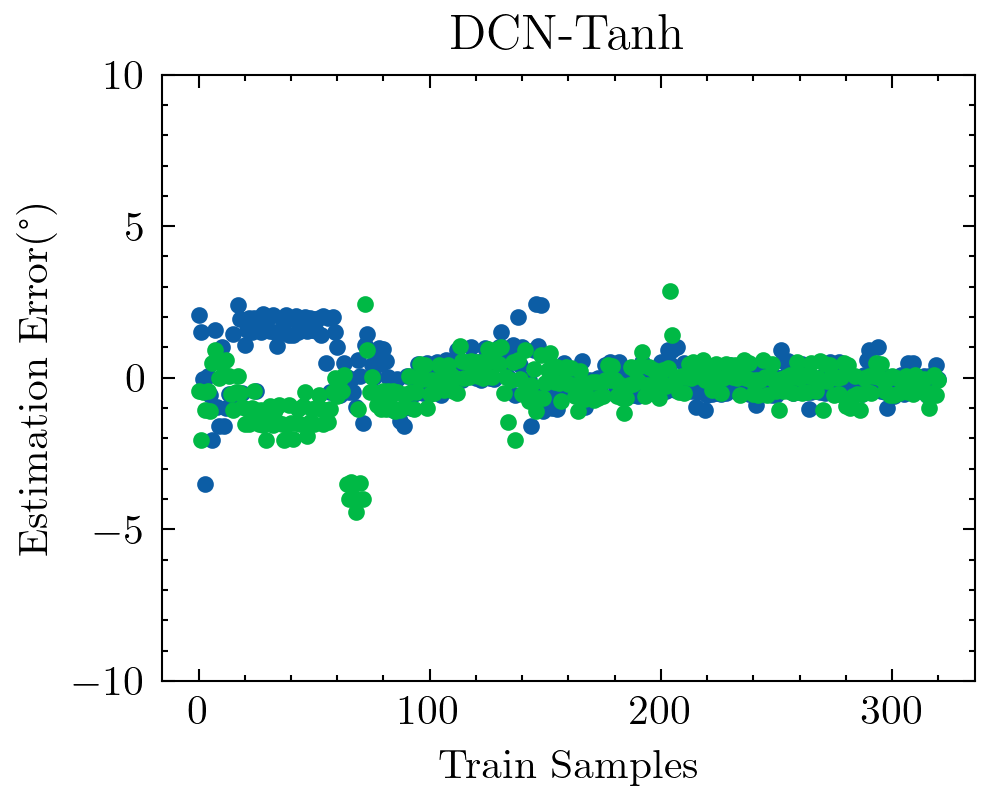

In [50]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-10,10)
    a = np.zeros((K, r2))
    a[0,:] = doa_cnntanh[1,:]
    a[1,:] = doa_cnntanh[0,:]
    plt.plot((a - DOA_train).T,'.')
    plt.title('DCN-Tanh')
    plt.xlabel('Train Samples')
    plt.ylabel('Estimation Error(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_Tanh_err.pdf')
    plt.show()

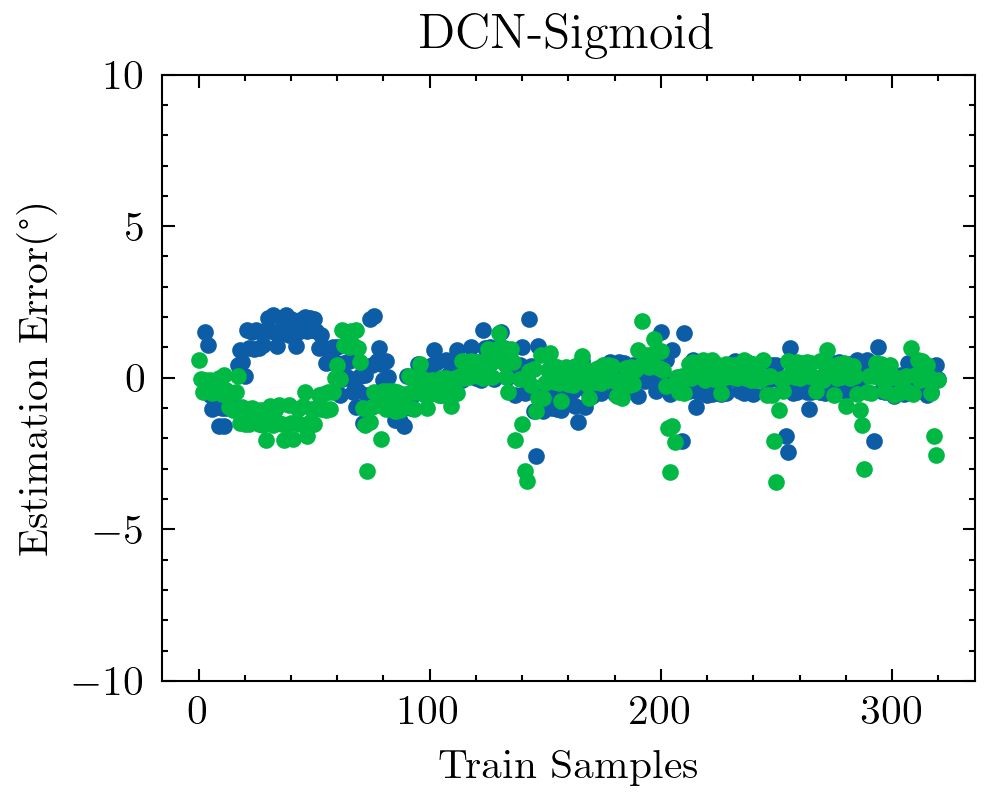

In [51]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-10,10)
    a = np.zeros((K, r2))
    a[0,:] = doa_cnnsigmoid[1,:]
    a[1,:] = doa_cnnsigmoid[0,:]
    plt.plot((a - DOA_train).T,'.')
    plt.title('DCN-Sigmoid')
    plt.xlabel('Train Samples')
    plt.ylabel('Estimation Error(°)')
    plt.savefig(figurepath + 'SampleIndex/DCN_Sigmoid_err.pdf')
    plt.show()

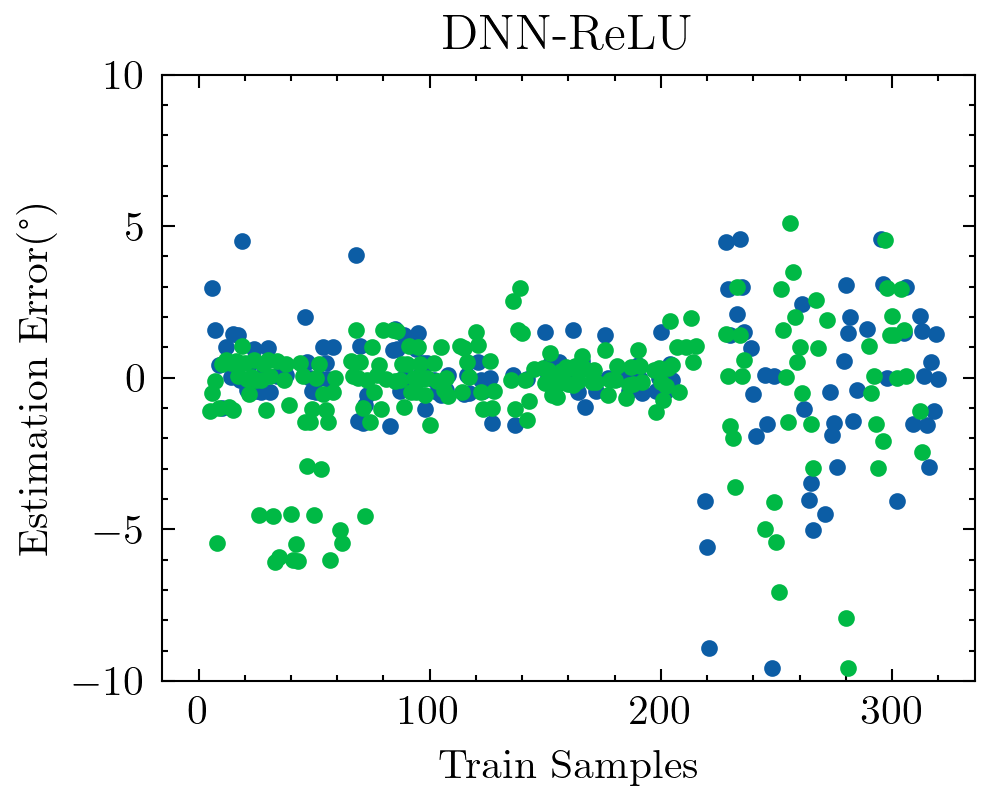

In [52]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-10,10)
    a = np.zeros((K, r2))
    a[0,:] = doa_dnnrelu[1,:]
    a[1,:] = doa_dnnrelu[0,:]
    plt.plot((a - DOA_train).T,'.')
    plt.title('DNN-ReLU')
    plt.xlabel('Train Samples')
    plt.ylabel('Estimation Error(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_ReLU_err.pdf')
    plt.show()

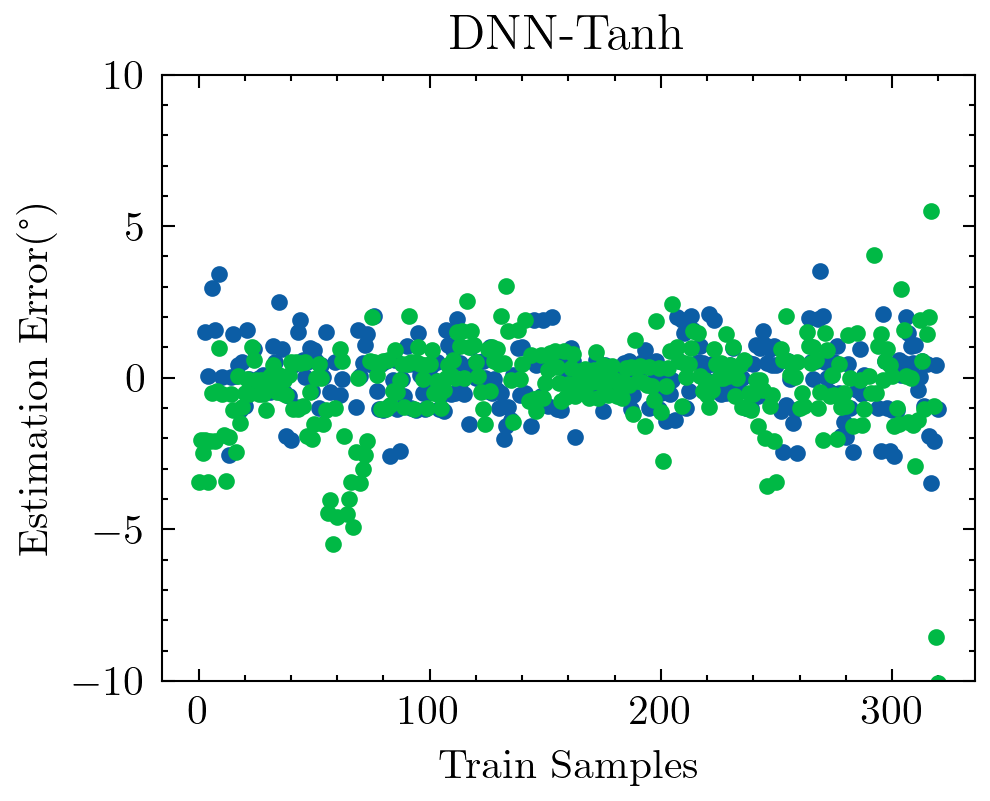

In [53]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-10,10)
    a = np.zeros((K, r2))
    a[0,:] = doa_dnntanh[1,:]
    a[1,:] = doa_dnntanh[0,:]
    plt.plot((a - DOA_train).T,'.')
    plt.title('DNN-Tanh')
    plt.xlabel('Train Samples')
    plt.ylabel('Estimation Error(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_Tanh_err.pdf')
    plt.show()

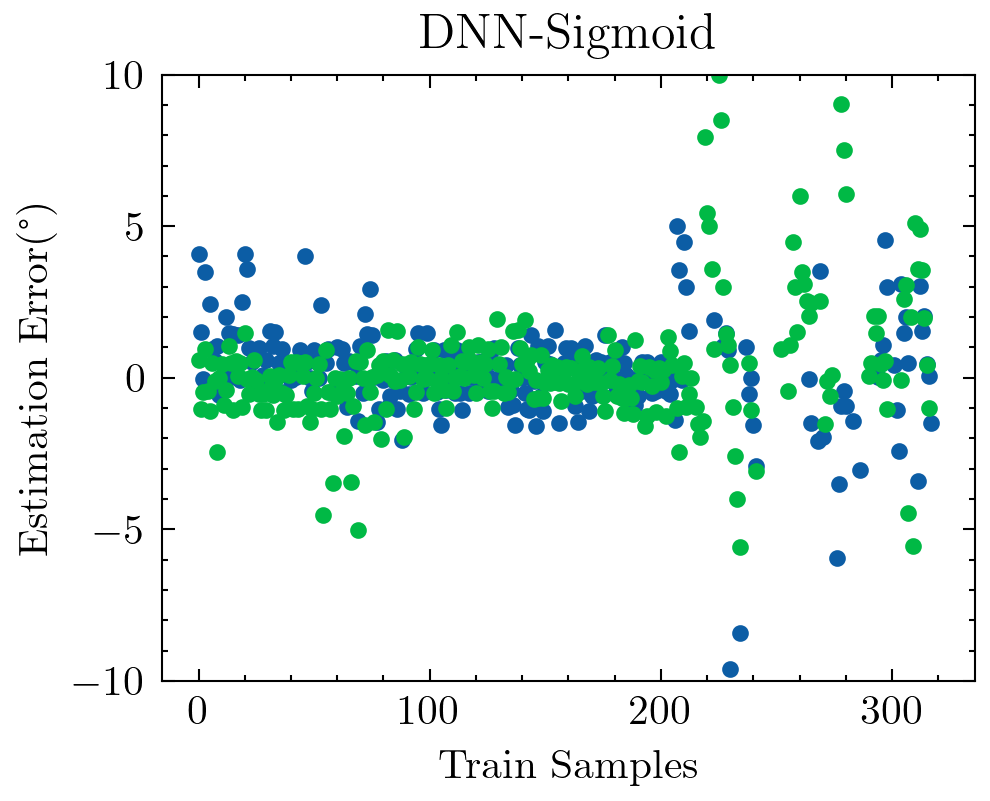

In [54]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-10,10)
    a = np.zeros((K, r2))
    a[0,:] = doa_dnnsigmoid[1,:]
    a[1,:] = doa_dnnsigmoid[0,:]
    plt.plot((a - DOA_train).T,'.')
    plt.title('DNN-Sigmoid')
    plt.xlabel('Train Samples')
    plt.ylabel('Estimation Error(°)')
    plt.savefig(figurepath + 'SampleIndex/DNN_Sigmoid_err.pdf')
    plt.show()

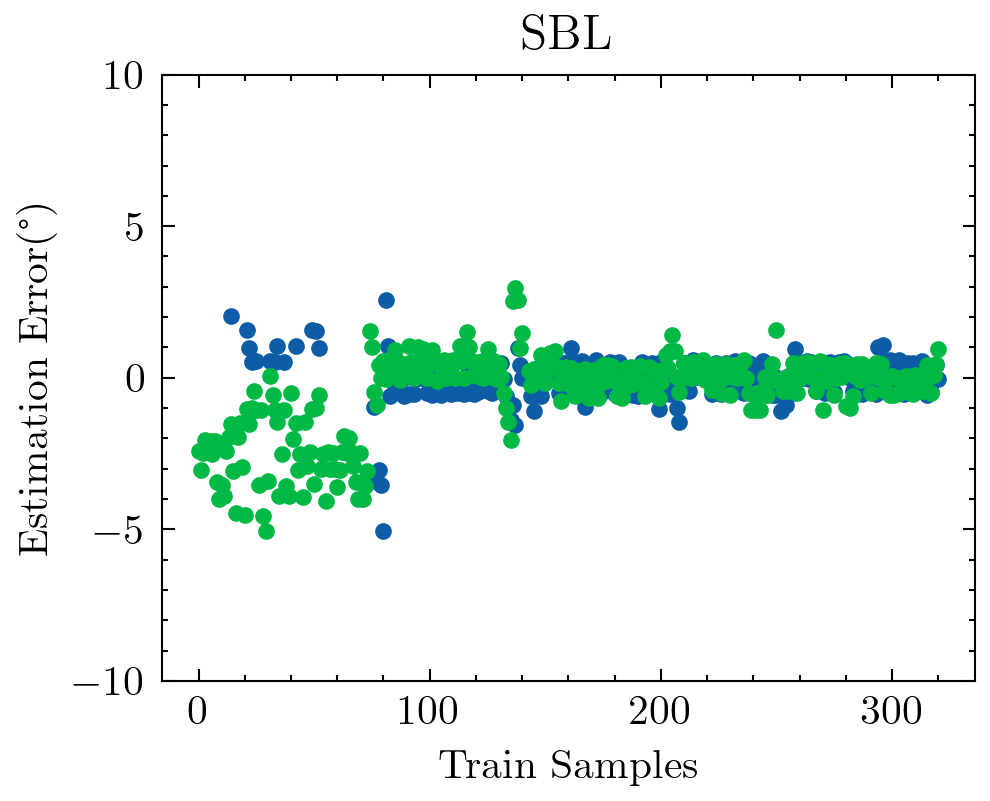

In [55]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-10,10)
    a = np.zeros((K, r2))
    a[0,:] = doa_sbl[1,:]
    a[1,:] = doa_sbl[0,:]
    plt.plot((a - DOA_train).T,'.')
    plt.title('SBL')
    plt.xlabel('Train Samples')
    plt.ylabel('Estimation Error(°)')
    plt.savefig(figurepath + 'SampleIndex/SBL_err.pdf')
    plt.show()

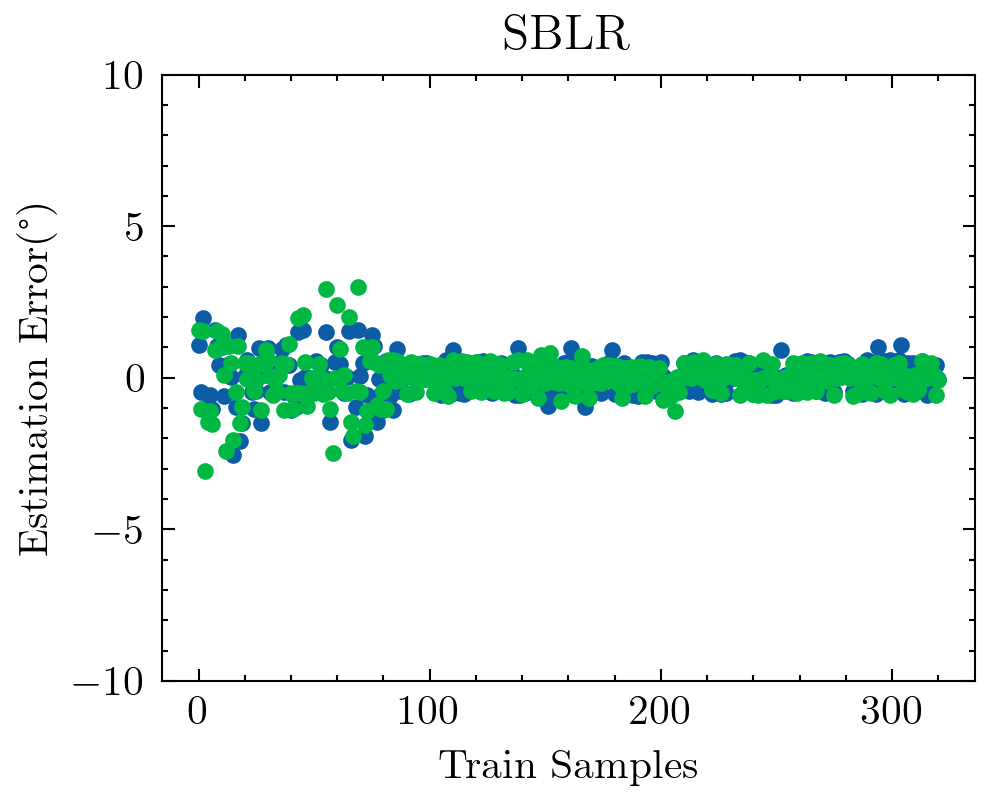

In [56]:
with plt.style.context(['science']):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.ylim(-10,10)
    a = np.zeros((K, r2))
    a[0,:] = doa_sblr[1,:]
    a[1,:] = doa_sblr[0,:]
    plt.plot((a - DOA_train).T,'.')
    plt.title('SBLR')
    plt.xlabel('Train Samples')
    plt.ylabel('Estimation Error(°)')
    plt.savefig(figurepath + 'SampleIndex/SBLR_err.pdf')
    plt.show()